<a href="https://colab.research.google.com/github/monjjjjj/stockprice_prediction/blob/main/stock_pred_LSTM_timestep60.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import the training set
dataset_train = pd.read_csv('/content/drive/MyDrive/StockPrice_prediction/google_2012_2016_trian.csv')  # 讀取訓練集
training_set = dataset_train.iloc[:, 1:2].values  # 取「Open」欄位值

In [4]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [5]:
X_train = []   #預測點的前 60 天的資料
y_train = []   #預測點
for i in range(60, 1258):  # 1258 是訓練集總數
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [6]:
def build_model():
  model = Sequential()
  model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 50))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))

  model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  print(model.summary())

  return model

In [7]:
model = build_model()
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [8]:
dataset_test = pd.read_csv('/content/drive/MyDrive/StockPrice_prediction/google_2017_test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [9]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # Feature Scaling

X_test = []
for i in range(60, 80):  # timesteps一樣60； 80 = 先前的60天資料+2017年的20天資料
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

In [10]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)  # to get the original scale
np.savetxt("prediction.csv", predicted_stock_price, delimiter=",")

1/1 [==============================] - 1s 1s/step


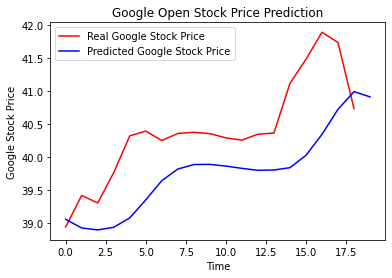

In [11]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')  # 紅線表示真實股價
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')  # 藍線表示預測股價
plt.title('Google Open Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()